In [1]:
#!pip install textblob
#!pip install wordcloud

In [1]:
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import DataFrame
import numpy as np

from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
from textblob import TextBlob
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

In [6]:
dataset_path = 'file:data.csv'
dataset = pd.read_csv(dataset_path, index_col=0)
#dataset
df = DataFrame(dataset)
df.shape
df.head(5)
#f.info()

C:\Users\wl879\AppData\Local\Temp\ipykernel_34988\1844132728.py:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(dataset_path, index_col=0)


,Unnamed: 0,tweet_id,time,tweet,retweet_count
1,1,1543382261164302337,2022-07-02 23:53:00,@kilundeezy Hii ndio ubaya ya kukosa degre😂😂😂....,0
2,2,1543379565648773121,2022-07-02 23:42:17,Mathira MP Rigathi Gachagua says Azimio la Umo...,0
5,5,1543377927773081603,2022-07-02 23:35:47,@LakesideBy @DavidNdii @SilviaWangeci2 @Nation...,0
6,6,1543377130201006084,2022-07-02 23:32:37,@alvinsabuya @ahmednasirlaw Uhuru is the Azimi...,0
7,7,1543377046105120770,2022-07-02 23:32:17,@PWamugunda @DavidNdii Hivyo ndivyo naingia Az...,0


### pre-processing tweets

In [3]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

#notes about re.sub: https://towardsdatascience.com/regex-essential-for-nlp-ee0336ef988d
def preprocess_tweet(tweet):
    tweet = re.sub(r'\d+', '', str(tweet))  # remove numbers
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', str(tweet))  # remove hyperlinks
    tweet = re.sub(r'http?:\/\/.*[\r\n]*', '', str(tweet))  # remove hyperlinks
    tweet = re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))  # remove forward of tweet
    tweet = re.sub(r'(@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))  # remove user name
    tweet = re.sub(r'[^a-zA-Z ]', '', str(tweet))  # remove punctuation, only keep words
    tweet = str(tweet).lower()  # lower case
    pure_text = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            pure_text.append(WordNetLemmatizer().lemmatize(token, pos='v'))
    return pure_text
def connect_token(tweet):
    tweet = ' '.join(tweet)
    return tweet

df['retweet_count'] = df['retweet_count'].astype('int')
df['time'] = pd.to_datetime(df['time'])

df['tweet_pure']  = df['tweet'].apply(preprocess_tweet)
df['tweet_final']  = df['tweet_pure'].apply(connect_token)
df.drop_duplicates(subset=['tweet_final'], keep='last', inplace=True)  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wl879\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wl879\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
#df['tweet_pure'].head(10)
#df['tweet_final'].head(10)
df.sample(5)
#df.head(5)

,Unnamed: 0,tweet_id,time,tweet,retweet_count,tweet_pure,tweet_final
29929,29928,1542722635641274369,2022-07-01 04:11:53,"Our incoming first family, we need a loving an...",0,"[incoming, family, need, love, god, fear, fami...",incoming family need love god fear family char...
34921,34920,1542582326013607936,2022-06-30 18:54:20,@kipmurkomen @WilliamsRuto Jamaa alikuwa anaca...,0,"[jamaa, alikuwa, anacalculate, pesa, ataiba]",jamaa alikuwa anacalculate pesa ataiba
86132,111350,1539065841567801346,2022-06-14 10:53:03,@PistonsWRLD no ivey is the clear cut 5th best...,0,"[ivey, clear, cut, th, best, stud, like, keega...",ivey clear cut th best stud like keegan murray...
42404,1265,1542481908600373248,2022-06-30 12:15:19,"Kshs. 200,000 cheque to Each Kenyan every year...",6,"[kshs, cheque, kenyan, year, things, bang, tim...",kshs cheque kenyan year things bang time root ...
1858130,231294,1539139761859973127,2022-06-21 06:54:49,@SilasWaf @EkesaAustin_1 @NelsonHavi If it's n...,0,"[tribal, luo, political, aspirant, go, raila, wo]",tribal luo political aspirant go raila wo


### general word popularity 

(-0.5, 1199.5, 799.5, -0.5)

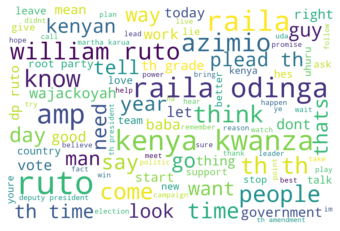

In [5]:

# Plotting Word Cloud 
allWords = ' '.join([twts for twts in df['tweet_final']])
wordcloud_set = WordCloud(width = 1200, height = 800,
                          background_color="white", mode="RGB",
                          max_words=100,
                          random_state = 12, max_font_size = 119).generate(allWords)
plt.imshow(wordcloud_set, interpolation = 'bilinear')
plt.axis('off')
#plt.savefig('general_word_popularity.png')

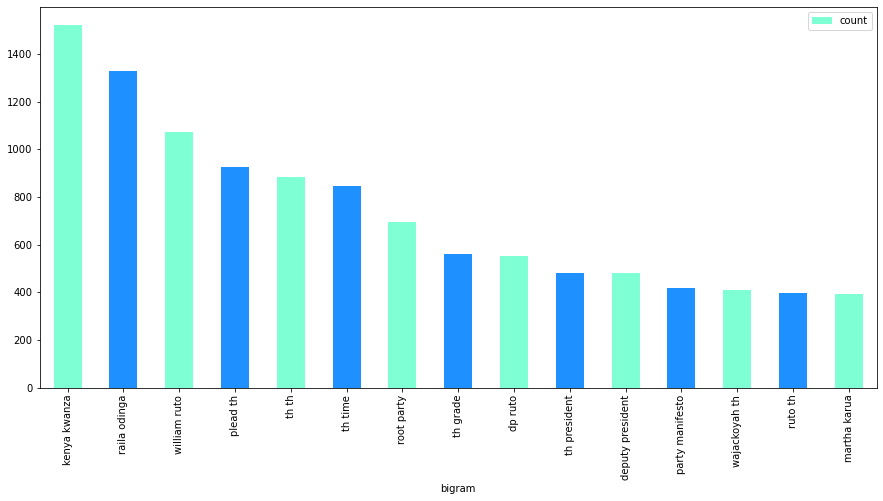

In [6]:
import matplotlib.pyplot as plt

tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df['tweet_final'])
total_words = tfidf_matrix.sum(axis=0) 

#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 

word_plot = bigram.head(15)


fig = word_plot.plot(x ='bigram', y='count', kind = 'bar',
                  #title = "Bigram disribution for the top 15 words in the Tweets regarding Kenya's election", 
                  figsize = (15,7), color=['aquamarine', 'dodgerblue'])
#plt.savefig('disribution_of_top_15_words.png')

## extract presodential candidates and their parties from tweets

In [7]:
# note: Presidential candidates and their parties:  (from https://en.wikipedia.org/wiki/2022_Kenyan_general_election#Presidential_candidates)
#William Ruto, leader of the United Democratic Alliance , under Kwanza Alliance party, also called deputy
#Raila Odinga, leader of the Orange Democratic Movement, under Azimio la Umoja One Kenya Alliance, also called baba
#George Wajackoyah, leader of the Roots Party Kenya
#David Waihiga Mwaure, leader of the Agano Party

def find_candidates(string):
    candidates_list = ['william', 'ruto', 'deputy', 'raila', 'odinga', 'baba', 'george', 'wajackoyah', 'david', 'mwaure']
    result_candidates= 'None'
    for term in candidates_list:
        if term in string:
            result_candidates = term
    return result_candidates


def find_party(string):
    party_list = ['assimio', 'uda', 'anc', 'odm', 'ford kenya', 
                  'kwanza', 'azimio',  'root', 'kwisha', 
                  'wiper', 'maendeleo', 'dap', 'chama cha kazi', 'hustler nation']
    result_party = 'None'
    for term in party_list:
        if term in string:
            result_party = term
    return result_party

df['candidates'] = df['tweet_final'].apply(find_candidates)
df['party'] = df['tweet_final'].apply(find_party)

# rename
df =df.replace({'candidates' : {'william' : 'William Ruto', 
                                'ruto' : 'William Ruto',
                                'deputy' : 'William Ruto',
                                'raila': 'Raila Odinga',
                                'odinga': 'Raila Odinga',
                                'baba' : 'Raila Odinga',
                                'george': 'George Wajackoyah',
                                'wajackoyah': 'George Wajackoyah',
                                'david': 'David Waihiga Mwaure',
                                'mwaure': 'David Waihiga Mwaure'}})

df =df.replace({'party' : {'kwanza': 'Kenya Kwanza',
                               'uda': 'Kenya Kwanza',
                               'hustler nation': 'Kenya Kwanza',
                               'kwisha': 'Kenya Kwanza',
                               'root': 'Roots Party',
                               'azimio': 'azimio OKA alliance',
                               'assimio':'azimio OKA alliance',
                               'odm': 'azimio OKA alliance'}})


In [8]:
df.sample(10)

,Unnamed: 0,tweet_id,time,tweet,retweet_count,tweet_pure,tweet_final,candidates,party
24143,24143,1540634706026401793,2022-06-25 09:55:12,@polyigathe must be told the truth and we aren...,0,"[tell, truth, arent, beg, somali, people, righ...",tell truth arent beg somali people right busin...,None,azimio OKA alliance
28437,28436,1542746614648946689,2022-07-01 05:47:10,Galana Kulalu gobbled 15billion and got us 3sa...,0,"[galana, kulalu, gobble, billion, get, sack, m...",galana kulalu gobble billion get sack maize se...,William Ruto,None
166670,50629,1541110041176072194,2022-06-26 17:24:00,@KikiArnold4 @MikeSonko Raila si Mungu shame o...,0,"[raila, si, mungu, shame]",raila si mungu shame,Raila Odinga,None
189094,5459,1542591684088942595,2022-06-30 19:31:32,@kipmurkomen @WilliamsRuto Mimi heri ni kwame ...,0,"[mimi, heri, ni, kwame, kwa, hiii, uongo, ya, ...",mimi heri ni kwame kwa hiii uongo ya tangu nme...,None,None
186245,2610,1542848292949721089,2022-07-01 12:31:12,@Kenyans Why is Professor Wajackoyah not doing...,0,"[professor, wajackoyah, snake, farm, earn, via...",professor wajackoyah snake farm earn vial veno...,George Wajackoyah,None
173774,57733,1540722409258352647,2022-06-25 15:43:42,Nobody can beat Raila in a free and fair elect...,2,"[beat, raila, free, fair, election, ruto, know...",beat raila free fair election ruto know head o...,Raila Odinga,None
113905,113904,1540242790466068481,2022-06-24 07:57:52,@RephaelTuju They are trembling because Ruto i...,0,"[tremble, ruto, take, presidency]",tremble ruto take presidency,William Ruto,None
1940008,315375,1538861091656282112,2022-06-20 12:27:29,RT @UDAPartyKe: ... one of their leaders given...,2,"[leaders, give, job, right, podium, sign, char...",leaders give job right podium sign charter the...,None,None
90611,115833,1538929925499105280,2022-06-14 10:53:03,We are delighted to receive the news that we h...,0,"[delight, receive, news, award, best, communit...",delight receive news award best community radi...,None,None
15860,15860,1541817441982070785,2022-06-28 16:14:58,"In Azimio la Ugatuzi, it's Baba's plan to incr...",1,"[azimio, la, ugatuzi, babas, plan, increase, f...",azimio la ugatuzi babas plan increase find giv...,Raila Odinga,azimio OKA alliance


# who have the highest attention

In [9]:
group = df.groupby(["candidates"])
candidate_count = group.size().reset_index(name='count')
candidate_count

,candidates,count
0,David Waihiga Mwaure,932
1,George Wajackoyah,20265
2,None,215116
3,Raila Odinga,56151
4,William Ruto,61708


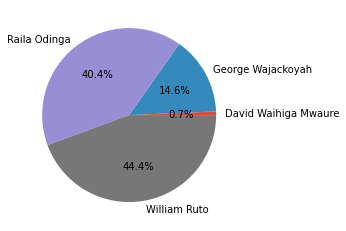

<Figure size 432x288 with 0 Axes>

In [10]:
plt.style.use('ggplot')
candidates = ['David Waihiga Mwaure', 'George Wajackoyah','Raila Odinga', 'William Ruto']
count = [932, 20265, 56151, 61708]
plt.pie(count, labels = candidates, autopct = '%1.1f%%')
plt.show()
plt.savefig('candidate_pie.png')

In [11]:
group = df.groupby(["party"])
party_count = group.size().reset_index(name='count')
party_count

,party,count
0,Kenya Kwanza,17963
1,None,293731
2,Roots Party,5598
3,anc,9300
4,azimio OKA alliance,27074
5,chama cha kazi,33
6,dap,267
7,ford kenya,43
8,maendeleo,86
9,wiper,77


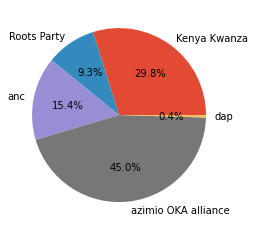

<Figure size 432x288 with 0 Axes>

In [12]:
# visualize top 5 parties using pie
plt.style.use('ggplot')
candidates = ['Kenya Kwanza', 'Roots Party','anc', 'azimio OKA alliance', 'dap']
count = [17963, 5598, 9300, 27074, 267]
plt.pie(count, labels = candidates, autopct = '%1.1f%%')
plt.show()
plt.savefig('party_pie.png')

# sentiment analysis of each candidate
## predict winner via public attention and sentiment analysis

In [13]:
# note: sentiment of subjectivity and polarity from textblob, https://stackabuse.com/sentiment-analysis-in-python-with-textblob/

def getPolarity(text):
  return TextBlob(text).sentiment.polarity
df['Polarity'] = df['tweet_final'].apply(getPolarity)   ##new column, polarity

In [16]:
# convert polarity to sentiment, if output > 0, means positive sentiment; if output = 0, means neutral sentiment; if output < 0, means negative sentiment
df['sentiment'] = np.where(df['Polarity'] > 0, 'Positive', 'Negative')
df.loc[df.Polarity == 0, 'sentiment'] = 'Neutral'

In [17]:
df.head()

,Unnamed: 0,tweet_id,time,tweet,retweet_count,tweet_pure,tweet_final,candidates,party,Polarity,sentiment
1,1,1543382261164302337,2022-07-02 23:53:00,@kilundeezy Hii ndio ubaya ya kukosa degre😂😂😂....,0,"[hii, ndio, ubaya, ya, kukosa, degre, azimios,...",hii ndio ubaya ya kukosa degre azimios economi...,None,azimio OKA alliance,0.0,Neutral
6,6,1543377130201006084,2022-07-02 23:32:37,@alvinsabuya @ahmednasirlaw Uhuru is the Azimi...,0,"[uhuru, azimio, candidate, visit, jerusalem]",uhuru azimio candidate visit jerusalem,None,azimio OKA alliance,0.0,Neutral
7,7,1543377046105120770,2022-07-02 23:32:17,@PWamugunda @DavidNdii Hivyo ndivyo naingia Az...,0,"[hivyo, ndivyo, naingia, azimio, kwanza, hii, ...",hivyo ndivyo naingia azimio kwanza hii story y...,None,azimio OKA alliance,0.2,Positive
8,8,1543374776286199808,2022-07-02 23:23:15,The similarities between the merchant of Venic...,0,"[similarities, merchant, venice, merchant, sug...",similarities merchant venice merchant sugoi su...,None,azimio OKA alliance,0.1,Positive
11,11,1543373085814013954,2022-07-02 23:16:32,@MairuraRatemo Yeah azimio minions are such wi...,0,"[yeah, azimio, minions, wicked, propagandists]",yeah azimio minions wicked propagandists,None,azimio OKA alliance,0.0,Neutral


In [18]:
# divide the dataset into subset according to candidate

# William Ruto
df_ruto = df[df['candidates'] == 'William Ruto']
print(df_ruto.head(2))

#Raila Odinga
df_raila = df[df['candidates'] == 'Raila Odinga']
#print(df_raila.head(2))

#George Wajackoyah
df_wajackoyah = df[df['candidates'] == 'George Wajackoyah']
#print(df_wajackoyah.head(2))

#David Waihiga Mwaure
df_david = df[df['candidates'] == 'David Waihiga Mwaure']
#print(df_david.head(2))

    Unnamed: 0             tweet_id                time  \
187        187  1543329684162740229 2022-07-02 20:24:05   
256        256  1543322334228013056 2022-07-02 19:54:52   

                                                 tweet  retweet_count  \
187  @TomasNjeranga @TheStarKenya Wewe nawewe uko n...              0   
256  Shame @HonJpMwirigi No peu... Tukutane kesho A...              0   

                                            tweet_pure  \
187  [wewe, nawewe, uko, na, ushoga, uhuru, deputy,...   
256  [shame, peu, tukutane, kesho, auki, pesa, kwen...   

                                           tweet_final    candidates  \
187  wewe nawewe uko na ushoga uhuru deputy prime m...  William Ruto   
256  shame peu tukutane kesho auki pesa kwenu kura ...  William Ruto   

                   party  Polarity sentiment  
187  azimio OKA alliance       0.0   Neutral  
256  azimio OKA alliance       0.0   Neutral  


In [19]:
#total sentiment
group = df.groupby(["sentiment"])
total_sentiment_count = group.size().reset_index(name='count')
total_sentiment_count

,sentiment,count
0,Negative,54911
1,Neutral,194644
2,Positive,104617


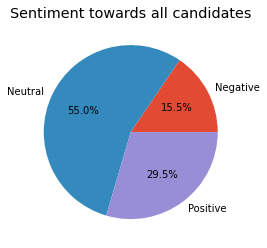

<Figure size 432x288 with 0 Axes>

In [36]:
# visualize total sentiment

plt.style.use('ggplot')
sentiment = ['Negative', 'Neutral','Positive']
count = [54911, 194644, 104617]
plt.pie(count, labels = sentiment, autopct = '%1.1f%%')
title = "Sentiment towards all candidates"
plt.title(title)
plt.show()
plt.savefig('total_sentiment_pie.png')

In [28]:
#sentiment towards William Ruto
group_ruto = df_ruto.groupby(["sentiment"])
ruto_sentiment_count = group_ruto.size().reset_index(name='ruto_count')
ruto_sentiment_count

,sentiment,ruto_count
0,Negative,9255
1,Neutral,36674
2,Positive,15779


In [29]:
#sentiment towards Raila Odinga
group_raila = df_raila.groupby(["sentiment"])
raila_sentiment_count = group_raila.size().reset_index(name='raila_count')
raila_sentiment_count

,sentiment,raila_count
0,Negative,8683
1,Neutral,30895
2,Positive,16573


In [30]:
#sentiment towards George Wajackoyah
group_wajackoyah = df_wajackoyah.groupby(["sentiment"])
wajackoyah_sentiment_count = group_wajackoyah.size().reset_index(name='wajackoyah_count')
wajackoyah_sentiment_count

,sentiment,wajackoyah_count
0,Negative,2254
1,Neutral,12512
2,Positive,5499


In [31]:
#sentiment towards David Waihiga Mwaure
group_david = df_david.groupby(["sentiment"])
david_sentiment_count = group_david.size().reset_index(name='david_count')
david_sentiment_count

,sentiment,david_count
0,Negative,143
1,Neutral,488
2,Positive,301


[Text(0.25, 0, 'William Ruto'),
 Text(1.25, 0, 'Raila Odinga'),
 Text(2.25, 0, 'George Wajackoyah'),
 Text(3.25, 0, 'David Waihiga Mwaure')]

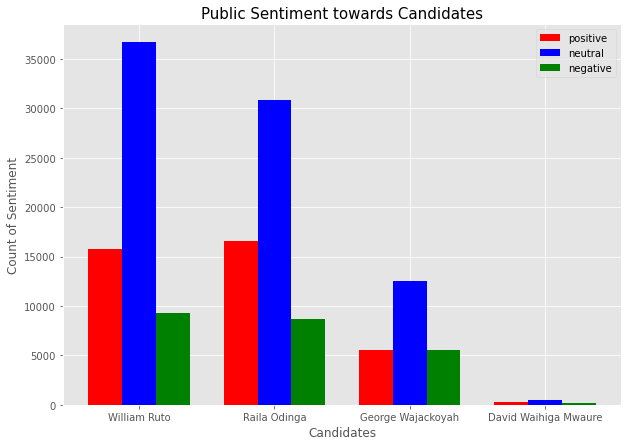

In [35]:
candidates = ["William Ruto", "Raila Odinga", 
              "George Wajackoyah", "David Waihiga Mwaure"]
positive = [15779, 16573, 5499, 301]
neutral = [36674, 30895, 12512, 488]
negative = [9255, 8683, 5499, 143]

xticks = np.arange(len(candidates))

fig, ax = plt.subplots(figsize=(10, 7))

ax.bar(xticks, positive, width=0.25, label="positive", color="red")

ax.bar(xticks + 0.25, neutral, width=0.25, label="neutral", color="blue")

ax.bar(xticks + 0.5, negative, width=0.25, label="negative", color="green")

ax.set_title("Public Sentiment towards Candidates", fontsize=15)
ax.set_xlabel("Candidates")
ax.set_ylabel("Count of Sentiment")
ax.legend()

ax.set_xticks(xticks + 0.25)
ax.set_xticklabels(candidates)

In [60]:
#score for each candidate: 2 for positive, 1 for neutral, -1 for negative
score_ruto = ruto_sentiment_count.ruto_count[0] * (-1) + ruto_sentiment_count.ruto_count[1] + ruto_sentiment_count.ruto_count[2]
score_raila = raila_sentiment_count.raila_count[0] * (-1) +raila_sentiment_count.raila_count[1] +raila_sentiment_count.raila_count[2]
score_wajackoyah = wajackoyah_sentiment_count.wajackoyah_count[0] * (-1) + wajackoyah_sentiment_count.wajackoyah_count[1] +wajackoyah_sentiment_count.wajackoyah_count[2]
score_david = david_sentiment_count.david_count[0] * (-1) + david_sentiment_count.david_count[1] +david_sentiment_count.david_count[2]
print("score of ruto:", score_ruto)
print("score of raila:", score_raila)
print("score of wajackoyah:", score_wajackoyah)
print("score of david:", score_david)

score of ruto: 43198
score of raila: 38785
score of wajackoyah: 15757
score of david: 646


# popular words for different candidates

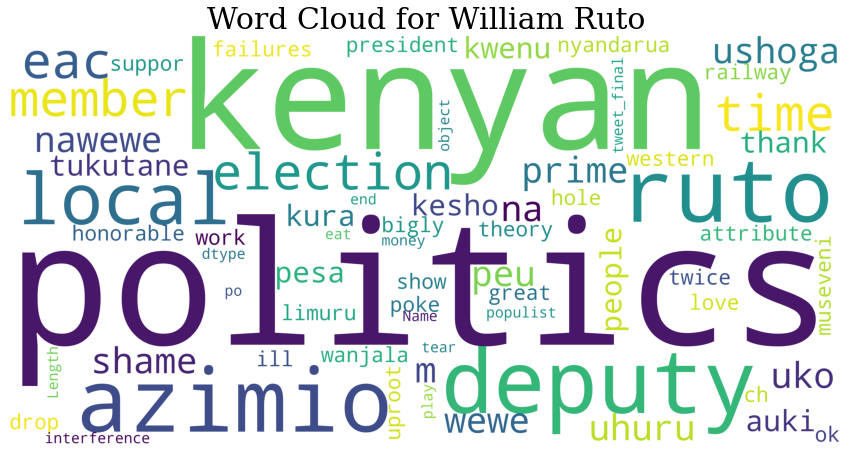

In [38]:
def wordcloud(data,title):
    text = str(data.tweet_final)
    wc = WordCloud(max_font_size=100,max_words=500,scale=10,relative_scaling=0.6,background_color='white').generate(text)

    plt.figure(figsize=(15,10))
    plt.title(title,{'fontsize':30,'family':'serif'})
    plt.axis('off')
    plt.imshow(wc)
    
wordcloud(df_ruto, 'Word Cloud for William Ruto')

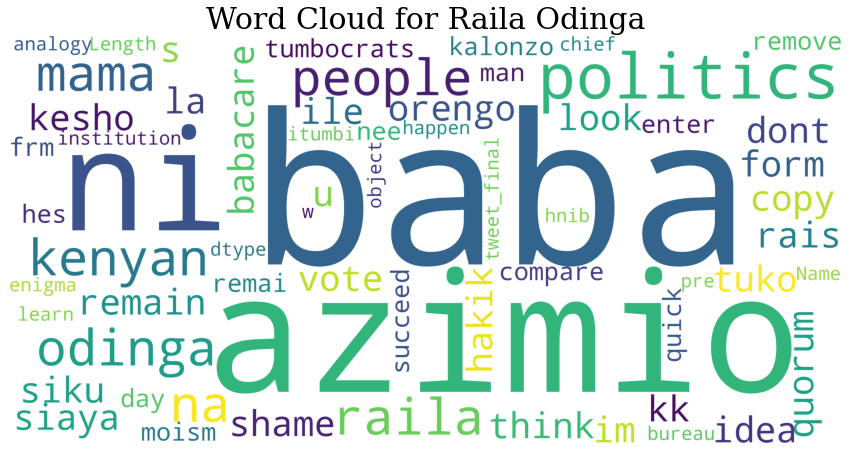

In [39]:
wordcloud(df_raila, 'Word Cloud for Raila Odinga')

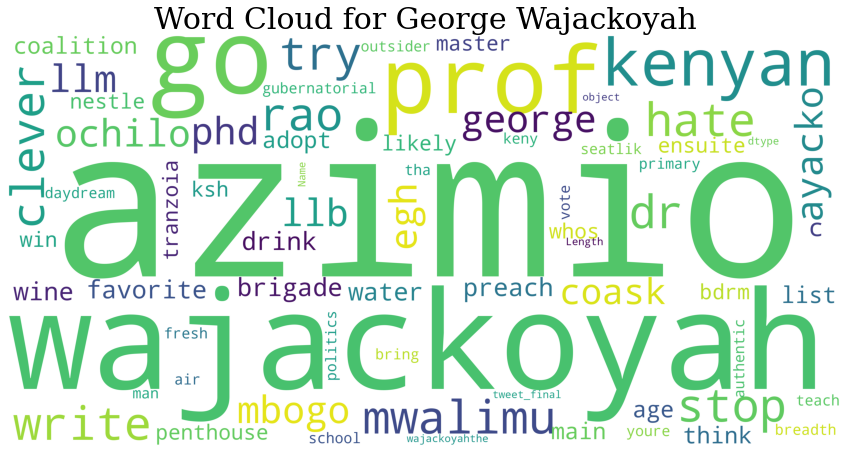

In [40]:
wordcloud(df_wajackoyah, 'Word Cloud for George Wajackoyah')

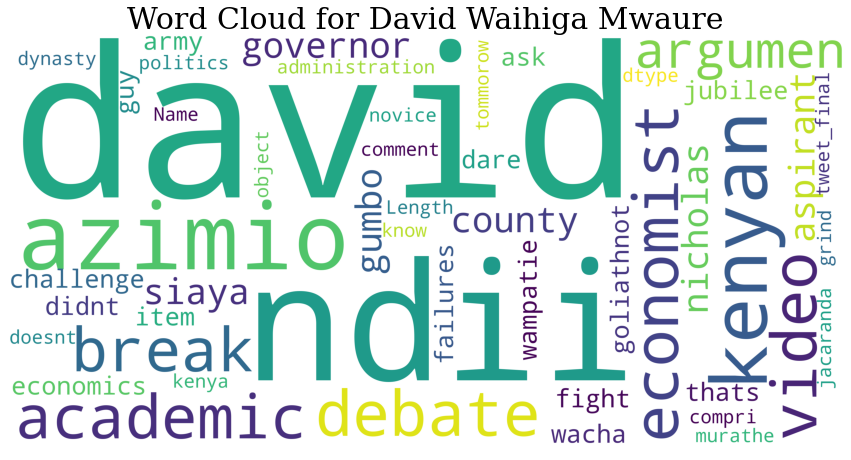

In [41]:
wordcloud(df_david, 'Word Cloud for David Waihiga Mwaure')